In [ ]:
# YRHacks 2023 - HAIL (Lynn Tao, Hamshini Gnanabaskaran, Amy Lin)
# Project name: iProtect

# Referenced tutorial: https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/

# Mounting Drive + Cloning Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# symbolic link so that /mydrive points to /content/gdrive/MyDrive/
!ln -s /content/drive/MyDrive/ /myDrive

Mounted at /content/drive


In [ ]:
%cd /myDrive/yrhacks2023

/content/drive/MyDrive/yrhacks2023


In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# Download Correctly Formatted Custom Dataset  (YOLOv5 PyTorch)

In [ ]:
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [ ]:
# %cd myDrive/yrhacks2023/yolov5
# python code with fields filled in (from annotated images on Roboflow)
# Roboflow URL: https://universe.roboflow.com/yrhacks2023/eye-tiredness

from roboflow import Roboflow
rf = Roboflow(api_key="zqmQIiA3NC6A3fDPQV1e")
project = rf.workspace("yrhacks2023").project("eye-tiredness")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to eye-tiredness-2 in yolov5pytorch:: 100%|██████████| 460/460 [00:02<00:00, 163.49it/s]


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- healthy
- tired
nc: 2
roboflow:
  license: CC BY 4.0
  project: eye-tiredness
  url: https://universe.roboflow.com/yrhacks2023/eye-tiredness/dataset/2
  version: 2
  workspace: yrhacks2023
test: ../test/images
train: eye-tiredness-2/train/images
val: eye-tiredness-2/valid/images


# Define Model Configuration and Architecture

In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#model configuration (taken from tutorial)
%cat models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
#copy information from previous 2 steps to yaml file

%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Training YOLOv5 Model

In [ ]:
# train yolov5s on custom dataset
# 416x416 images, batch size 16, 400 epochs/complete iterations of dataset
%%time
%cd /myDrive/yrhacks2023/yolov5
!python train.py --img 416 --batch 16 --epochs 400 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache


[Errno 2] No such file or directory: '/content/yolov5/'
/content/drive/MyDrive/yrhacks2023/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/drive/MyDrive/yrhacks2023/yolov5/eye-tiredness-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=400, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 44 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameter

# Using Trained Weights to Predict Eye Tiredness
Run with images uploaded in the 'test/images' folder.

In [ ]:
# use the best weights to predict user's images
%cd /myDrive/yrhacks2023/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

# can replace "../test/images" with url of image:
# !python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source "https://i.pinimg.com/originals/2f/b0/80/2fb080370ed29bd3ba9a6acae5427de5.jpg"

/content/drive/MyDrive/yrhacks2023/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
image 1/4 /content/drive/MyDrive/yrhacks2023/test/images/DqQQ6S6X0AIZ4YY.jpg: 416x416 2 tireds, 233.4ms
image 2/4 /content/drive/MyDrive/yrhacks2023/test/images/close-up-of-teenage-girls-face-CUF40656.jpg: 416x288 2 healthys, 148.7ms
image 3/4 /content/drive/MyDrive/yrhacks2023/test/images/justinbieber3.jpg: 416x416 2 tireds,

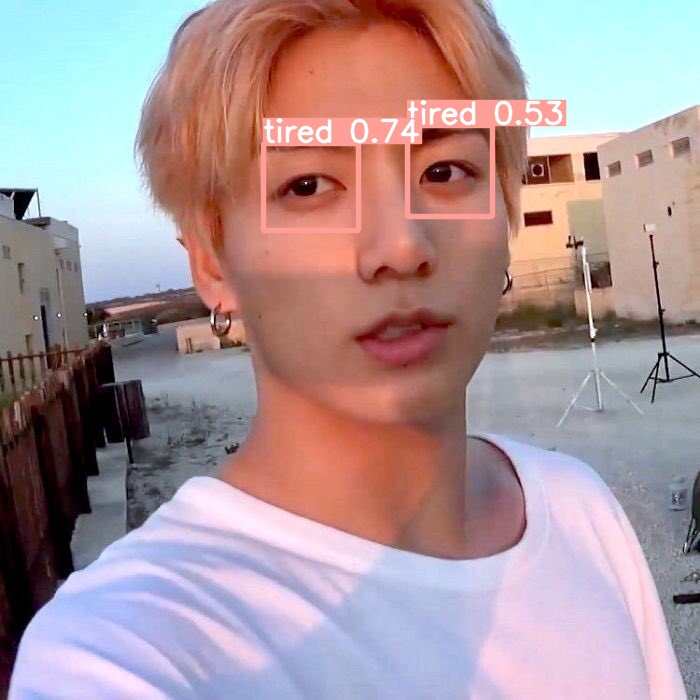

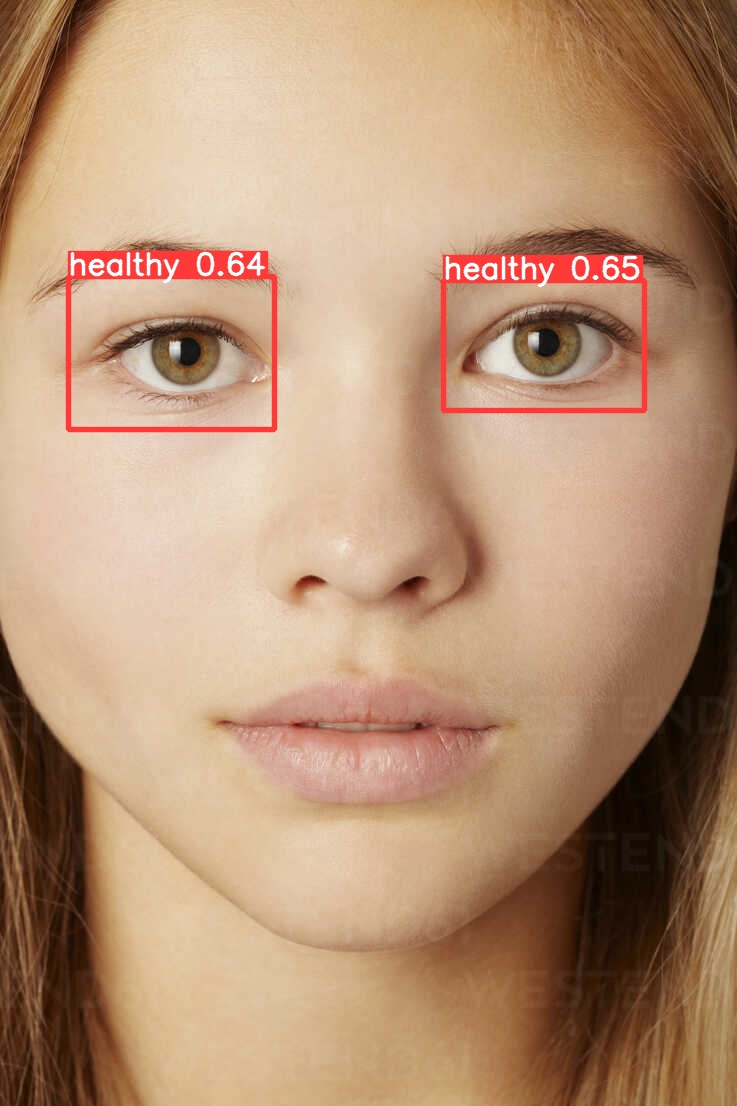

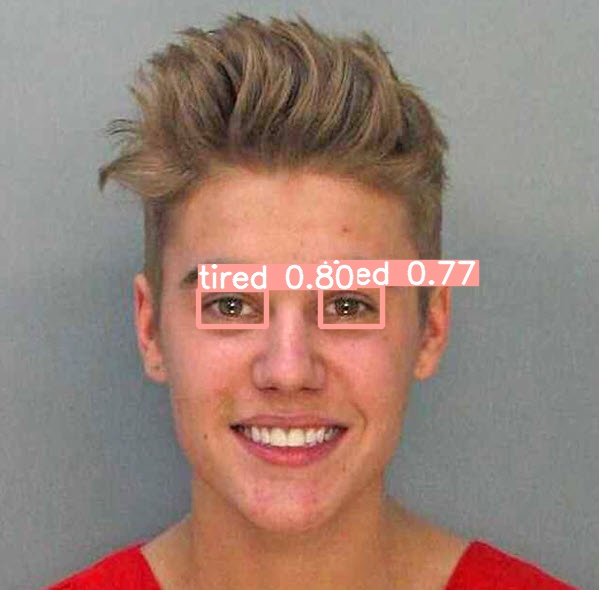

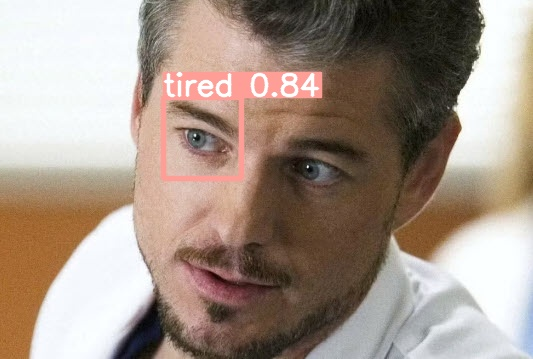

In [ ]:
# display identified images from previous step
import glob
from IPython.display import Image, display

for imageName in glob.glob('/myDrive/yrhacks2023/yolov5/runs/detect/exp6/*.jpg'): #look for JPG images under this folder
    display(Image(filename=imageName))
    print("\n")